A. Loading data
1. Load coordinates in map
2. Load lakes
3. Load lakes sent to Denis
4. Load hydrolakes
5. Load all the lakes
B. Load available time series (ground data)
1. Load argentina's Time series
2. Load loccss time series
3. Load other time series (Brazil)
4. Load VS time series 
C. Plot time series with altimeter data


In [1]:
#Import 

import geoplot as gplt
import pandas as pd
from shapely.geometry import Point
import fiona
import folium
import os
import gzip
import glob
import shutil
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
current_dir=os.getcwd()
current_dir

'/home/angelica/Documents/py_linux/pylocss/src'

In [4]:
#!/usr/bin/env python
# encoding: utf-8
#Sylvain functions
""" Python3 script showing how to load altimetry time series computed from
    GDR altimetry files using AlTiS software
"""


import os
import time as tm
import numpy as np
from pylab import plt
from datetime import datetime as dt
import pandas as pd
import scipy.interpolate as sc


def decimalyear2yearmonthdayhour(decimaltime_curr):
    '''
    Function to convert time vector in decimal year to
    correponding year, month, day and hour for each date
    '''
    # Compute year for the input date in decimal year
    year_curr = int(np.floor(decimaltime_curr))
    # Compute number of days in current year for the input date
    #  (01 January = day 1)
    start_yearcurr = dt(year=year_curr, month=1, day=1)
    start_nextyear = dt(year=year_curr+1, month=1, day=1)
    totnumdays_yearcurr = (tm.mktime(start_nextyear.timetuple()) -
                           tm.mktime(start_yearcurr.timetuple()))/(24.0*3600.0)
    numdays_decimaltimecurr = int(np.floor((decimaltime_curr-year_curr) *
                                           totnumdays_yearcurr)) + 1
    # Compute month for the input date in decimal year
    ydm_curr = dt.strptime(str(year_curr)+" "+str(numdays_decimaltimecurr),
                           "%Y %j")
    month_curr = ydm_curr.month
    day_curr = ydm_curr.day
    # Compute hour for the input date in decimal year
    #  (numdays_decimaltimecurr-1 because 01 January
    #  19 hour is actualy day 0 from starting year + 19 hours)
    hour_curr = int((decimaltime_curr-year_curr -
                     float(numdays_decimaltimecurr-1)/totnumdays_yearcurr) *
                    totnumdays_yearcurr*24)
    return (year_curr, month_curr, day_curr, hour_curr)


def yearday2decimalyear(year_curr, day_curr):
    '''
    Function to convert date defined by its year (year_curr)
    and the number of days elapsed since the begining of the
    year (day_curr), with the covention that the first day is
    day 1 (and not 0) and the last day of the year is day 366
    for leap year and 365 for others.
    For example, February 3rd, 2019 corresponds to:
    year_curr = 2019
    day_curr = 34
    '''
    start_yearcurr = dt(year=int(year_curr), month=1, day=1)
    start_nextyear = dt(year=int(year_curr)+1, month=1, day=1)
    totnumdays_yearcurr = (tm.mktime(start_nextyear.timetuple()) -
                           tm.mktime(start_yearcurr.timetuple()))/(24.0*3600.0)
    decimalyear = year_curr + float(day_curr)/totnumdays_yearcurr
    return (decimalyear)


def yearmonthdayhourminutesec2decimalyear(year_curr, month_curr, day_curr,
                                          hour_curr, minute_curr, sec_curr):
    '''
    Function to convert time vector in year, month, day, hour,
    minute and second to correponding decimal year for each date
    '''
    date_curr = dt(int(year_curr), int(month_curr), int(day_curr),
                   int(hour_curr), int(minute_curr), int(sec_curr))
    dayyear_curr = int(date_curr.strftime("%j"))
    decimaltime_curr = yearday2decimalyear(year_curr, dayyear_curr - 1 +
                                           hour_curr/24.0 +
                                           minute_curr/(24.0*60.0) +
                                           sec_curr/(24.0*60.0*60.0))
    return decimaltime_curr


def load_altis(falti, ncoldate, ncolh, nodataalti=-9999):
    '''
    Function to load altimetry water elevation in AlTiS csv format
    Inputs:
    - falti: AlTiS csv file
    - ncoldate: name of the column with date of each sample time series
    - ncolh: name of the column with water elevation time series
    - nodataalti: no data values in the water elevation time series
    Outputs:
    - alti_year: year of all samples in the time series
    - alti_month: month of all samples in the time series
    - alti_day: day of all samples in the time series
    - alti_hour: hour of all samples in the time series
    - alti_minute: minute of all samples in the time series
    - alti_height: water elevation of all samples in the time series
                   referenced to the mission reference geoid (and not the
                   ellipsoid)
    '''
    # Retrieve in-situ water level file header
    fin = open(falti)
    isheader = fin.readline()
    fin.close()
    isheader_split = (isheader.replace('\n', '')).split(',')
    # Extract water elevation
    patterncol = ncolh
    icolh = [i for i, s in enumerate(isheader_split)
             if patterncol.lower() in s.lower()]
    if len(icolh) == 0:
        print(('Error: no column '+ncolh+' in '+falti))
        alti_height = None
    elif len(icolh) > 1:
        print(('Error: more than one column '+ncolh+' in '+falti))
        alti_height = None
    elif len(icolh) == 1:
        alti_height = np.loadtxt(falti, skiprows=1, delimiter=',',
                                 usecols=[icolh[0]])
    # Get lines with no data values
    ivaliddata = (alti_height > nodataalti).nonzero()
    # Extract date
    patterncol = ncoldate
    icold = [i for i, s in enumerate(isheader_split)
             if patterncol.lower() in s.lower()]
    if len(icold) == 0:
        print(('Error: no column '+ncoldate+' in '+falti))
        alti_date = None
    elif len(icold) > 1:
        print(('Error: more than one column '+ncoldate+' in '+falti))
        alti_date = None
    elif len(icold) == 1:
        alti_date = np.loadtxt(falti, skiprows=1, delimiter=',',
                               usecols=[icold[0]], dtype='U')
    if alti_date is None:
        alti_year = None
        alti_month = None
        alti_day = None
        alti_hour = None
        alti_minute = None
    else:
        split_vecdate = ' '.join(alti_date.tolist()).replace(':', ' ')\
                        .replace('-', ' ').split(' ')
        alti_year = np.array(list(map(int, split_vecdate[::6])))
        alti_month = np.array(list(map(int, split_vecdate[1::6])))
        alti_day = np.array(list(map(int, split_vecdate[2::6])))
        alti_hour = np.array(list(map(int, split_vecdate[3::6])))
        alti_minute = np.array(list(map(int, split_vecdate[4::6])))

    return (alti_year[ivaliddata], alti_month[ivaliddata],
            alti_day[ivaliddata], alti_hour[ivaliddata],
            alti_minute[ivaliddata],
            alti_height[ivaliddata])


def main():
    '''
    Example showing how to use load_altis() and how to compute decimal year
    from altis (year, month, day, hour, minute) vectors
    '''
    falti = '../data/alti_timeseries/AlTiS_TimeSeries_Jason-3_0011_S2599.csv'
    ncoldate = 'date'  # Same value for Sentinel-3A/B
    ncolh = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
    # Load Altis Jason-3 altimetry time series
    (altiyear, altimonth, altiday, altihour, altiminute,
     altiwelev) = load_altis(falti, ncoldate, ncolh)
    # Compute decimal year from year/month/day from altimetry time series
    altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                               altiyear, altimonth, altiday, altihour,
                               altiminute, np.zeros(altiday.shape))))
    
    
    # Plot time series
    plt.figure(1)
    plt.plot(altidy, altiwelev-np.nanmean(altiwelev), '-ro', markersize=2.5)
    #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('Time (decimal year)', size=15, weight='bold')
    plt.ylabel('Water elev. anomalies (m)', size=15, weight='bold')
    plt.grid('on')
    plt.title(os.path.split(os.path.splitext(falti)[0])[1], size=15,
              weight='bold')
    plt.savefig(os.path.splitext(falti)[0]+'_exampleplot.png',
                bbox_inches='tight')
    
def interp_ts12ts2_stat(dy_ts1, data_ts1, dy_ts2, data_ts2):
    '''
    Linearly interpolate data from a first time series (ts1) to date of a
    second time series (ts2). Then compute Pearson correlation coefficient
    between interpolated ts1 and ts2, Nash-Sutcliffe coefficient of ts2 anom
    wrt ts1 anomalies, and root mean square difference from ts2 anomalies wrt
    to ts1 anomalies.
    Inputs:
    - dy_ts1: decimal time for first time series (ts1)
    - data_ts1: data for first time series (ts1)
    - dy_ts2: decimal time for second time series (ts2)
    - data_ts2: data for second time series (ts2)
    Outputs:
    - datast1_2_ts2dy: ts1 data at ts2 dates
    - corr_ts1ts2: correlation coefficient between ts1 and ts2 data
    - ns_ts2: ts2 minus time mean Nash-Sutcliffe coefficient wrt ts1 minus
              time mean
    - rmsd_ts2: root mean square difference between ts2 minus time mean and
                ts1 minus time mean
    - ampl_ts1: difference between max and min for interpolated ts1 time
                series over common time period with ts2
    '''
    # Interpolate linearly in-situ measurements to altimetry measurement times
    datast1_2_ts2dy = sc.griddata(dy_ts1, data_ts1, dy_ts2, method='linear')
    # Compute the correlation between altimetry and discharge
    icommon = ((np.isnan(datast1_2_ts2dy) == 0) &
               (np.isnan(data_ts2) == 0)).nonzero()
    if len(icommon[0]) > 1:
        datats2_commonts1 = data_ts2[icommon]
        datats1_commonts2 = datast1_2_ts2dy[icommon]
        # Correlation coefficient
        vec2corrcoef = np.zeros((2, datats2_commonts1.size))
        vec2corrcoef[0, :] = datats2_commonts1
        vec2corrcoef[1, :] = datats1_commonts2
        matcorr_ts1ts2 = np.corrcoef(vec2corrcoef)
        corr_ts1ts2 = matcorr_ts1ts2[0, 1]
        # Nash-Sutcliffe coefficient
        diffts = (datats2_commonts1 - np.nanmean(datats2_commonts1)) -\
            (datats1_commonts2 - np.nanmean(datats1_commonts2))
        ns_ts2 = 1 - np.sum(np.square(diffts)) / \
            np.sum(np.square(datats1_commonts2 -
                             np.nanmean(datats1_commonts2)))
        # RMS from ts2 wrt ts1
        rmsd_ts2 = np.linalg.norm(diffts)/np.sqrt(diffts.size)
        # Amplitude of ts1 time series over common date with ts2
        ampl_ts1 = np.max(datats1_commonts2) - np.min(datats1_commonts2)
    else:
        corr_ts1ts2 = np.nan
        ns_ts2 = np.nan
        rmsd_ts2 = np.nan
        ampl_ts1 = np.nan
    return (datast1_2_ts2dy, corr_ts1ts2, ns_ts2, rmsd_ts2, ampl_ts1)


def comp_insi_alti(finsi, insiname, falti, altivsname, ncoldate, ncolh,
                   ncolgeoid, outdir, fstat, fvolo=None, volovsname=None,
                   fstatvol=None):
    '''
    Compare in situ discharge and altimetry time series
    '''
    # Load in situ water level time series
    (indy, inh) = load_insi_volformat(finsi)
    # Load Altis altimetry time series
    (altiyear, altimonth, altiday, altihour, altiminute,
     altiwelev) = load_altis(falti, ncoldate, ncolh, ncolgeoid)
    # Interpolate in situ time series to altis dates
    altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                               altiyear, altimonth, altiday, altihour,
                               altiminute, np.zeros(altiday.shape))))
    (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
     ampl_insi) = interp_ts12ts2_stat(indy, inh, altidy, altiwelev)
    # Save statistics between alti and insi time series
    if (fstat is not None) and (os.path.exists(fstat)):
        line2save = (altivsname+';'+insiname+';' +
                     str(np.round(corr_alti_insi, decimals=2))+';' +
                     str(np.round(ns_alti_insi, decimals=2))+';' +
                     str(np.round(rmse_alti_insi, decimals=2))+';' +
                     str(np.round(ampl_insi, decimals=2))+'\n')
        ffstat = open(fstat, 'a')
        ffstat.write(line2save)
        ffstat.close()
    # Plots
    plt.close('all')
    plt.ion()
    # Plot in situ discharge and altimetry water elevation time series
    plt.figure(1)
    ax = plt.gca()
    plt.plot(indy, inh-np.nanmean(inh_2_altidy), 'bo', markersize=1)
    plt.plot(altidy, altiwelev-np.nanmean(altiwelev), 'ro', markersize=2.5)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.grid(b='on', axis='x')
    plt.legend((insiname, altivsname), loc='best', numpoints=1,
               framealpha=0.6)
    # plt.xlim(np.floor(np.min(altidy)), np.ceil(np.max(altidy)))
    plt.xlim(2016.0, np.ceil(np.max(altidy)))
    plt.xlabel('Time (decimal year)', size=15, weight='bold')
    plt.ylabel('Water elev. anomalies (m)', size=15, weight='bold')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        tick.label.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        tick.label.set_fontweight('bold')
    plt.title('alti/insi corr. = '+str(np.round(corr_alti_insi, 2)),
              size=15, weight='bold')
    plt.savefig(os.path.join(outdir, 'comp_'+altivsname+'_'+insiname+'.png'),
                bbox_inches='tight')
    plt.figure(2)
    ax = plt.gca()
    plt.plot(indy, inh, 'bo', markersize=1)
    plt.plot(altidy, altiwelev, 'ro', markersize=2.5)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.grid(b='on', axis='x')
    plt.legend((insiname, altivsname), loc='best', numpoints=1,
               framealpha=0.6)
    # plt.xlim(np.floor(np.min(altidy)), np.ceil(np.max(altidy)))
    plt.xlim(2016.0, np.ceil(np.max(altidy)))
    plt.xlabel('Time (decimal year)', size=15, weight='bold')
    plt.ylabel('Water elev. wrt geoid (m)', size=15, weight='bold')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        tick.label.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        tick.label.set_fontweight('bold')
    plt.title('alti/insi corr. = '+str(np.round(corr_alti_insi, 2)), size=15,
              weight='bold')
    plt.savefig(os.path.join(outdir, 'abs_comp_'+altivsname+'_'+insiname +
                             '.png'), bbox_inches='tight')


def comp_multiple_altis_insi():
    '''
    Compare altimetry water elevation time series from GDR file (generated
    with Altis) to in situ water elevation time series
    '''
    # Input directory
    altidir = '/home/biancama/partagewindows/ao_projets/LOCSS/alti/ts/'
    insidir = ('/home/biancama/partagewindows/ao_projets/LOCSS/insitu/ts_'
               'insitu/timeseries/')
    # Output directory
    outdir = ('/home/biancama/partagewindows/ao_projets/LOCSS/comp_alti_insi'
              '/altis_only')
    # Altis time series information
    ncoldate = 'date'
    ncolh = 'ice1_ku_SurfHeight_alti_median'
    ncolgeoids3 = 'geoid_01_median'
    ncolgeoidj3 = 'geoid_eigen6c4d_median'
    ncolgeoid_default = ncolgeoids3
    # Load file with in situ gage name associated with corresponding VS name
    fngages = ('/home/biancama/partagewindows/ao_projets/LOCSS/altis_'
               'locsslakes.csv')
    (altilist, insilist) = np.loadtxt(fngages, delimiter=';', unpack=True,
                                      dtype='U40,U75')
    # Create the text file to store alti/insi statistics
    fstat = os.path.join(outdir, 'stat_alti_insi.csv')
    ffstat = open(fstat, 'w')
    ffstat.write(('altivs_name;insigage_name;Corr;NSE_anom;RMSE_anom_m;'
                  'amplitudeinsi_m\n'))
    ffstat.close()
    # Loop over all VS/gage couples
    for icoupl in range(len(altilist)):
        altivsname = altilist[icoupl]
        falti = os.path.join(altidir, altivsname+'.csv')
        if altivsname.find('Sentinel-3A') > -1:
            ncolgeoid = ncolgeoids3
        elif altivsname.find('Jason-3') > -1:
            ncolgeoid = ncolgeoidj3
        else:
            ncolgeoid = ncolgeoid_default
        insiname = insilist[icoupl]
        finsi = os.path.join(insidir, insiname+'.txt')
        print('Comparison '+altivsname+' vs '+insiname)
        comp_insi_alti(finsi, insiname, falti, altivsname, ncoldate, ncolh,
                       ncolgeoid, outdir, fstat)


################______________END Sylvain functions

def load_ground_ts_csv(path, file_name,parse_dates=None, sep=',', day_first=True):
    
    #TODO: Validate path
    
    file_path=path+file_name
    
    df=pd.read_csv(file_path, sep=sep, parse_dates=parse_dates, dayfirst=day_first)
    return df


In [5]:
#Loading example Brazil

falti_S = '../data/alti_timeseries/AlTiS_TimeSeries_Sentinel-3A_0076_S2588.csv'
falti_J = '../data/alti_timeseries/AlTiS_TimeSeries_Jason-3_0011_S2599.csv'
ncoldate = 'date'  # Same value for Sentinel-3A/B
ncolh = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B

# Load Altis Jason-3 altimetry time series
(altiyear, altimonth, altiday, altihour, altiminute,
 altiwelev) = load_altis(falti_J, ncoldate, ncolh)
# Compute decimal year from year/month/day from altimetry time series
altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           altiyear, altimonth, altiday, altihour,
                           altiminute, np.zeros(altiday.shape))))

#load for sentinel 3 altimetry time series
(altiyear_s, altimonth_s, altiday_s, altihour_s, altiminute_s,
 altiwelev_s) = load_altis(falti_S, ncoldate, ncolh)
# Compute decimal year from year/month/day from altimetry time series
altidy_s = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           altiyear_s, altimonth_s, altiday_s, altihour_s,
                           altiminute_s, np.zeros(altiday_s.shape))))

#Read and prepare groundstation 
df_test_cp=load_ground_ts_csv('../data/','test_19060_segredo.csv',['date'], sep='\t')
df_test_cp['year'] =df_test_cp['date'].dt.year
df_test_cp['month']=df_test_cp['date'].dt.month
df_test_cp['day']  =df_test_cp['date'].dt.day
df_test_cp['hour'] =12

df_test_cp['decimal_y'] = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           df_test_cp['year'].array,df_test_cp['month'].array, df_test_cp['day'].array, df_test_cp['hour'].array, 
                             np.zeros(df_test_cp['year'].shape), np.zeros(df_test_cp['year'].shape))))




In [8]:
#Compute correlations
(datats1_2_ts2dy, corr_ts1ts2, ns_ts2, rmsd_ts2, ampl_ts1)=interp_ts12ts2_stat(dy_ts1=altidy, data_ts1=altiwelev, 
                                                                               dy_ts2=df_test_cp['decimal_y'].to_numpy(), data_ts2=df_test_cp['we'].to_numpy())

Text(0.5, 1.0, 'Water elevation (m)')

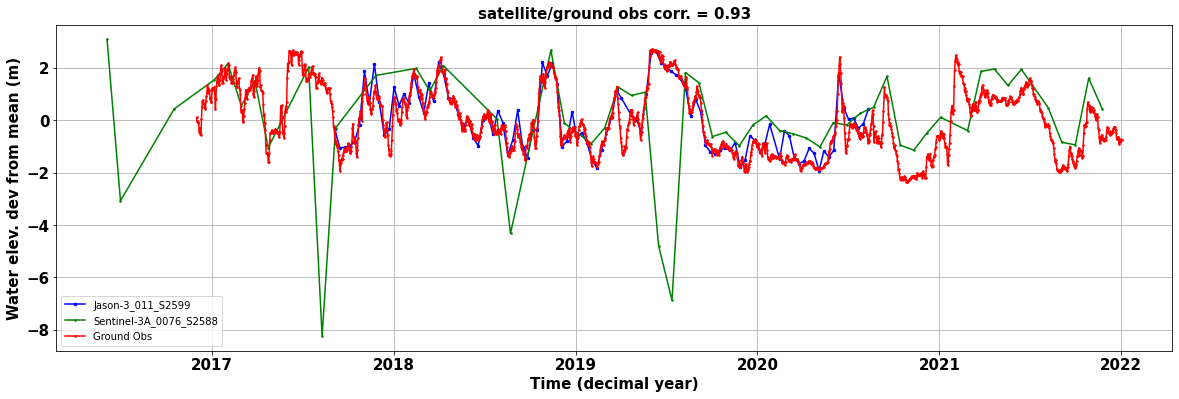

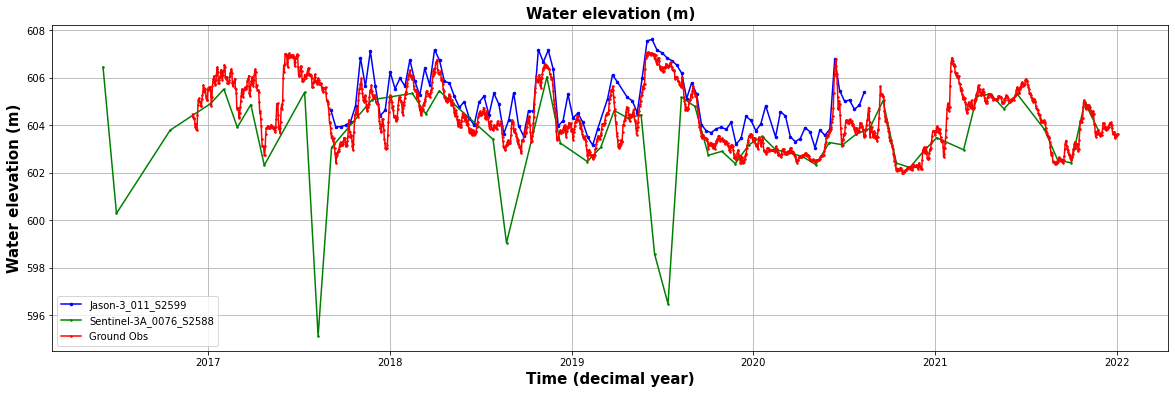

In [12]:
# Plot time series deviation from mean
plt.figure(1, figsize=(20, 6))
ax = plt.gca()
jplot=plt.plot(altidy, altiwelev-np.nanmean(altiwelev), '-bo', markersize=2.5, label='Jason-3_011_S2599')
splot=plt.plot(altidy_s, altiwelev_s-np.nanmean(altiwelev_s), '-go', markersize=1.5, label='Sentinel-3A_0076_S2588')
gplot=plt.plot(df_test_cp['decimal_y'], df_test_cp['we']-df_test_cp['we'].mean(), '-ro', markersize=1.5, label='Ground Obs')
#plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Time (decimal year)', size=15, weight='bold')
plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
plt.grid('on')
plt.legend()
# plt.title('Deviation from the mean time series comparison', size=15,
#           weight='bold')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    tick.label.set_fontweight('bold')
plt.title('satellite/ground obs corr. = '+str(np.round(corr_ts1ts2, 2)),
          size=15, weight='bold')
# plt.savefig(os.path.splitext(falti)[0]+'_br_segrado_plot.png',
#             bbox_inches='tight')

# Plot time series
plt.figure(2, figsize=(20, 6))
jplot=plt.plot(altidy, altiwelev, '-bo', markersize=2.5, label='Jason-3_011_S2599')
splot=plt.plot(altidy_s, altiwelev_s, '-go', markersize=1.5, label='Sentinel-3A_0076_S2588')
gplot=plt.plot(df_test_cp['decimal_y'], df_test_cp['we'], '-ro', markersize=1.5, label='Ground Obs')
#plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Time (decimal year)', size=15, weight='bold')
plt.ylabel('Water elevation (m)', size=15, weight='bold')
plt.grid('on')
plt.legend()
plt.title('Water elevation (m)', size=15,
          weight='bold')
# plt.savefig(os.path.splitext(falti)[0]+'_br_segrado_WE_plot.png',
#             bbox_inches='tight')

In [70]:
print(df_test_cp['decimal_y'].shape)
print(altidy_s.shape)
df_test=df_test_cp.loc[(df_test_cp['decimal_y']>np.min(altidy))&(df_test_cp['decimal_y']<np.nanmax(altidy))]
altidy_s_mask=(altidy_s>np.min(altidy))&(altidy_s>np.nanmax(altidy))
altidy_s_f=altidy_s[altidy_s_mask]
print(altidy_s_f.shape)
print(df_test['decimal_y'].shape)

(1858,)
(56,)
(16,)
(1071,)


Text(0.5, 1.0, 'Deviation from the mean time series comparison')

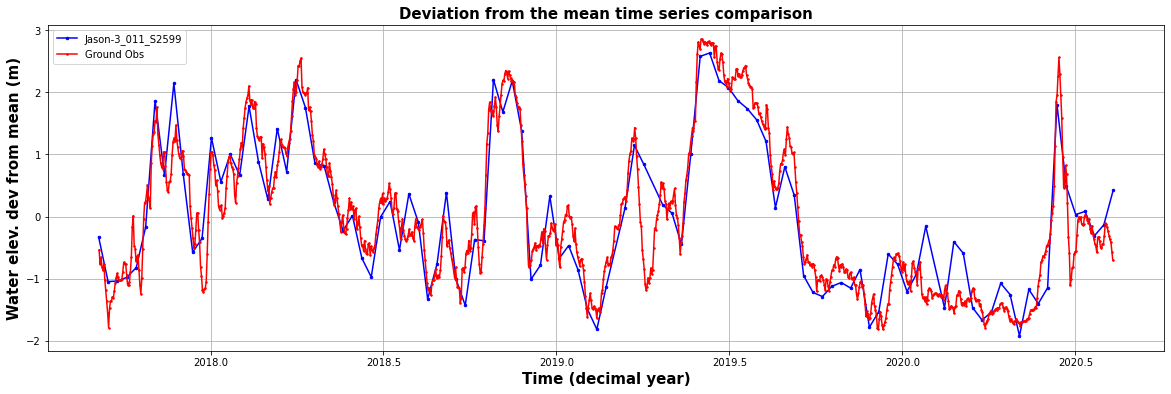

In [73]:

plt.figure(1, figsize=(20, 6))

jplot=plt.plot(altidy, altiwelev-np.nanmean(altiwelev), '-bo', markersize=2.5, label='Jason-3_011_S2599')
#splot=plt.plot(altidy_s_f, altiwelev_s-np.nanmean(altiwelev_s), '-go', markersize=1.5, label='Sentinel-3A_0076_S2588')
gplot=plt.plot(df_test['decimal_y'], df_test['we']-df_test['we'].mean(), '-ro', markersize=1.5, label='Ground Obs')
#plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Time (decimal year)', size=15, weight='bold')
plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
plt.grid('on')
plt.legend()
plt.title('Deviation from the mean time series comparison', size=15,
          weight='bold')
#plt.savefig(os.path.splitext(falti)[0]+'_br_segrado_plot.png',
#            bbox_inches='tight')


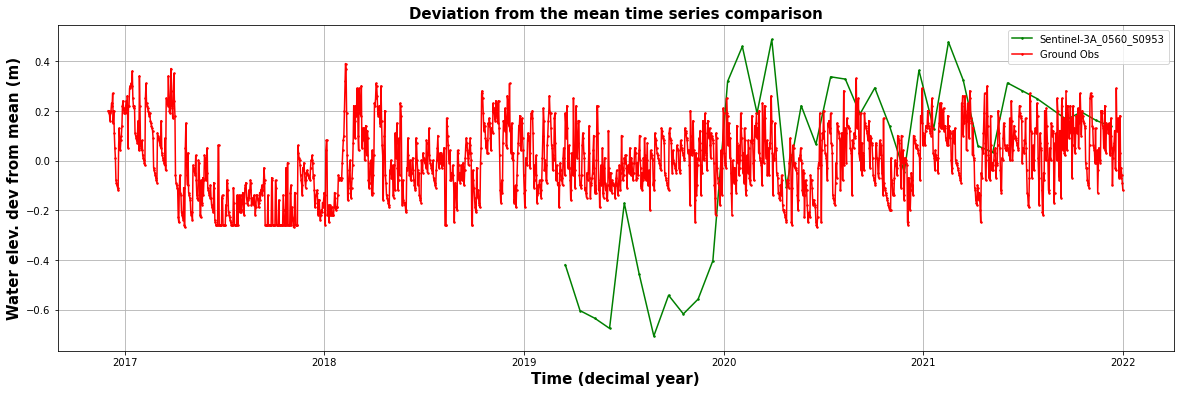

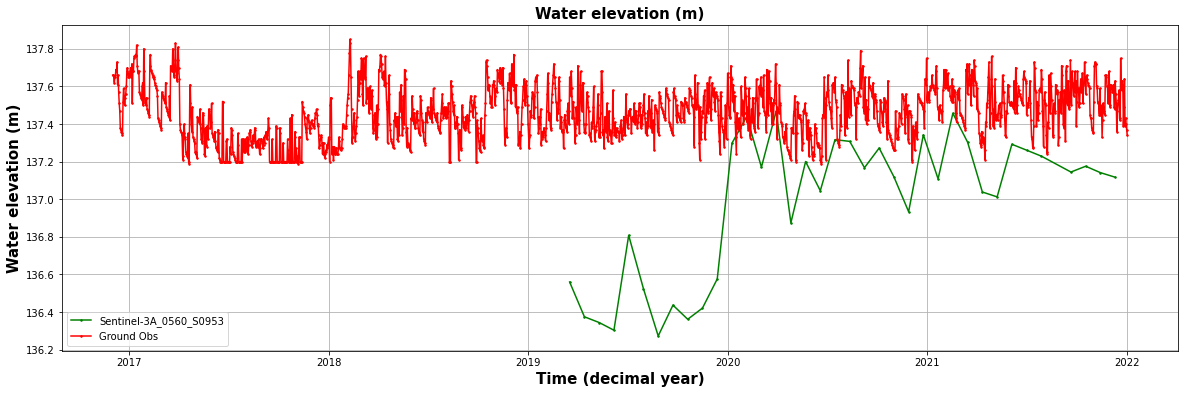

In [75]:
#Loading example Brazil

falti_S = '../data/alti_timeseries/AlTiS_TimeSeries_Sentinel-3A_0560_S0953.csv'
# falti_J = '../data/alti_timeseries/AlTiS_TimeSeries_Jason-3_0011_S2599.csv'
ncoldate = 'date'  # Same value for Sentinel-3A/B
ncolh = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B

# # Load Altis Jason-3 altimetry time series
# (altiyear, altimonth, altiday, altihour, altiminute,
#  altiwelev) = load_altis(falti_J, ncoldate, ncolh)
# # Compute decimal year from year/month/day from altimetry time series
# altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
#                            altiyear, altimonth, altiday, altihour,
#                            altiminute, np.zeros(altiday.shape))))

#load for sentinel 3 altimetry time series
(altiyear_s, altimonth_s, altiday_s, altihour_s, altiminute_s,
 altiwelev_s) = load_altis(falti_S, ncoldate, ncolh)
# Compute decimal year from year/month/day from altimetry time series
altidy_s = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           altiyear_s, altimonth_s, altiday_s, altihour_s,
                           altiminute_s, np.zeros(altiday_s.shape))))

#Read and prepare groundstation 
df_test_cp=load_ground_ts_csv('../data/','test_19126_xingo.csv',['date'], sep=',')
df_test_cp['year'] =df_test_cp['date'].dt.year
df_test_cp['month']=df_test_cp['date'].dt.month
df_test_cp['day']  =df_test_cp['date'].dt.day
df_test_cp['hour'] =12

df_test_cp['decimal_y'] = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           df_test_cp['year'].array,df_test_cp['month'].array, df_test_cp['day'].array, df_test_cp['hour'].array, 
                             np.zeros(df_test_cp['year'].shape), np.zeros(df_test_cp['year'].shape))))


# Plot time series deviation from mean
plt.figure(1, figsize=(20, 6))
# jplot=plt.plot(altidy, altiwelev-np.nanmean(altiwelev), '-bo', markersize=2.5, label='Jason-3_011_S2599')
splot=plt.plot(altidy_s, altiwelev_s-np.nanmean(altiwelev_s), '-go', markersize=1.5, label='Sentinel-3A_0560_S0953')
gplot=plt.plot(df_test_cp['decimal_y'], df_test_cp['we']-df_test_cp['we'].mean(), '-ro', markersize=1.5, label='Ground Obs')
#plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Time (decimal year)', size=15, weight='bold')
plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
plt.grid('on')
plt.legend()
plt.title('Deviation from the mean time series comparison', size=15,
          weight='bold')
plt.savefig(os.path.splitext(falti)[0]+'_br_segrado_plot.png',
            bbox_inches='tight')

# Plot time series
plt.figure(2, figsize=(20, 6))
# jplot=plt.plot(altidy, altiwelev, '-bo', markersize=2.5, label='Jason-3_011_S2599')
splot=plt.plot(altidy_s, altiwelev_s, '-go', markersize=1.5, label='Sentinel-3A_0560_S0953')
gplot=plt.plot(df_test_cp['decimal_y'], df_test_cp['we'], '-ro', markersize=1.5, label='Ground Obs')
#plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Time (decimal year)', size=15, weight='bold')
plt.ylabel('Water elevation (m)', size=15, weight='bold')
plt.grid('on')
plt.legend()
plt.title('Water elevation (m)', size=15,
          weight='bold')
plt.savefig(os.path.splitext(falti)[0]+'_br_xingo_WE_plot.png',
            bbox_inches='tight')

In [26]:
df_test_cp=load_ground_ts_csv('../data/','test_19060_segredo.csv',['date'], sep='\t')
df_test_cp['year'] =df_test_cp['date'].dt.year
df_test_cp['month']=df_test_cp['date'].dt.month
df_test_cp['day']  =df_test_cp['date'].dt.day
df_test_cp['hour'] =12

df_test_cp['decimal_y'] = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           df_test_cp['year'].array,df_test_cp['month'].array, df_test_cp['day'].array, df_test_cp['hour'].array, 
                             np.zeros(df_test_cp['year'].shape), np.zeros(df_test_cp['year'].shape))))

In [41]:
df=df_test_cp
df['we']-df['we'].mean()

0       0.107944
1      -0.022056
2      -0.012056
3      -0.052056
4      -0.092056
          ...   
1853   -0.832056
1854   -0.802056
1855   -0.762056
1856   -0.732056
1857   -0.742056
Name: we, Length: 1858, dtype: float64

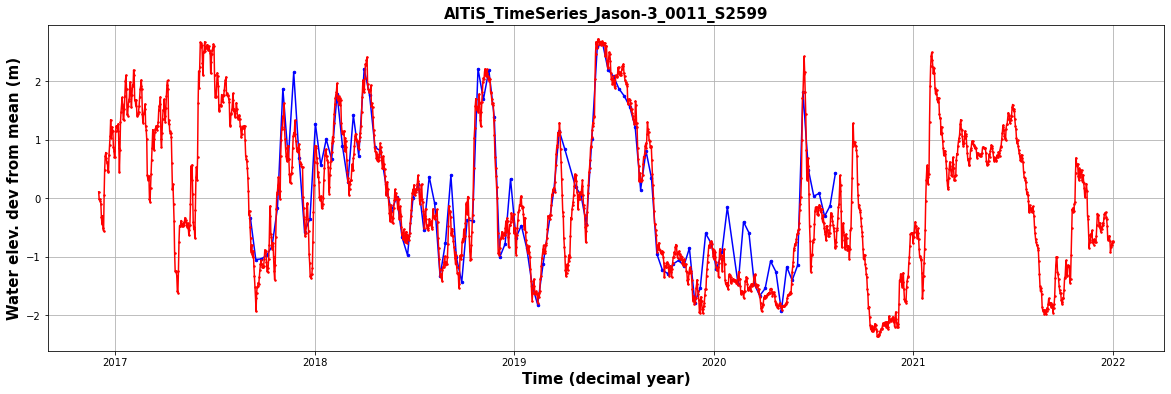

In [48]:
# Plot time series
plt.figure(1, figsize=(20, 6))
plt.plot(altidy, altiwelev-np.nanmean(altiwelev), '-bo', markersize=2.5)
plt.plot(df_test_cp['decimal_y'], df['we']-df['we'].mean(), '-ro', markersize=1.5)
#plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Time (decimal year)', size=15, weight='bold')
plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
plt.grid('on')
plt.title(os.path.split(os.path.splitext(falti)[0])[1], size=15,
          weight='bold')
plt.savefig(os.path.splitext(falti)[0]+'_br_segrado_plot.png',
            bbox_inches='tight')

1. Load coordinates in map DONE
2. Load lakes 
3. Load lakes gages sent to Denis DONE
4. Load hydrolakes SLOW (Change for only the lakes in the sublist)
5. Load all the lakes (Pending do the interception again in python)

In [27]:
#1.1 Coordinates from what Sylvain did
altis_path='../data/'
altis_fname='lonlat_vs_altis.csv'
df_altis=pd.read_csv(altis_path+altis_fname, sep=';')
#Convert to geodataframe
gdf_altis=gpd.GeoDataFrame(df_altis, geometry=gpd.points_from_xy(df_altis.lon, df_altis.lat))

#no need for the Dataframe anymore
del df_altis
gdf_altis.crs = 'epsg:4326'

#Load shapefile sent to Denis 
d_lakes_path='/home/angelica/Dropbox/Research/LOCSS/Denis_tracks/'
d_lakes_fname='lakes_to_denis_updated.shp'

gdf_dlakes=gpd.read_file(d_lakes_path+d_lakes_fname)

#hydrolakes in the lakes of interest TODO-LOAd only the relevant lakes for now
# hydrolakes_path='/home/angelica/Dropbox/Research/LOCSS/shapes/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/'
# hydrolakes_fname='HydroLakes_LT_10sk.shp'
# gdf_hydrolakes=gpd.read_file(hydrolakes_path+hydrolakes_fname)

#FROM HERE GO TO PLOT SPATIAL DATA

In [35]:
var='AR_20211018_FUTALAUFQUEN_Estacion 2286.xlsx'
postfix='.xlsx'
len(postfix)

path='/home/angelica/Dropbox/Research/LOCSS/other_lakes/Argentine'


['AR_20211018_LagoPosadas_Estacion 2832.xlsx',
 'AR_20211020_Gendarmeria_Estacion 2316.xlsx',
 'AR_20211020_Calafate_Estacion 2817.xlsx']

In [2]:
from ground_data import GroundObservations
import importlib
%load_ext autoreload
%autoreload 2




ValueError: Missing column provided to 'parse_dates': 'Fecha y Hora'

**Load time series**
1. Load argentina's Time series
2. Load loccss time series
3. Load other time series (Brazil)
4. Load VS time series 

In [14]:
#4 Load VS time series 
#Get the list of the data
path_vs_ts='../data/alti_timeseries/'
postfix='.csv'
files = [f for f in os.listdir(path_vs_ts) if (os.path.isfile(os.path.join(path_vs_ts, f))&
                                                  (f.endswith(postfix)))]
def get_df_from_file(path, file_name, col_date, col_height):

    falti = path+file_name
    #ncoldate = 'date'  # Same value for Sentinel-3A/B
    #ncolh = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
    # Load Altis Jason-3 altimetry time series
    (altiyear, altimonth, altiday, altihour, altiminute,
     altiwelev) = load_altis(falti, col_date, col_height)
    # Compute decimal year from year/month/day from altimetry time series
    altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                               altiyear, altimonth, altiday, altihour,
                               altiminute, np.zeros(altiday.shape))))
    return altidy

get_df_from_file(path_vs_ts,files[0], 'date', 'ice1_ku_SurfHeight_alti_median')

array([2018.93069444, 2019.00466705, 2019.07863965, 2019.15261225,
       2019.22658486, 2019.30055746, 2019.37453006, 2019.44850266,
       2019.52247527, 2019.59644787, 2019.67042047, 2019.74439307,
       2019.81836568, 2019.89233828, 2019.96631088, 2020.04017342,
       2020.11394391, 2020.1877144 , 2020.2614849 , 2020.33525539,
       2020.40902588, 2020.48279637, 2020.55656686, 2020.63033736,
       2020.70410785, 2020.77787834, 2020.85164883, 2020.92541932,
       2020.99918981, 2021.0731602 , 2021.1471328 , 2021.2211054 ,
       2021.29507801, 2021.36905061, 2021.44302321, 2021.51699581,
       2021.59096842, 2021.66494102, 2021.73891362, 2021.81288623,
       2021.88685883])

In [ ]:
#Plot spatial data lakes, gauges and virtual stations

m=gdf_altis.explore(name='VS from Sylvain', color='green')
gdf_dlakes.explore(name='Lakes for Denis', color='gray',
                   m=m)
gdf_hydrolakes.explore(name='Hydrolakes', color='blue', m=m)
folium.TileLayer('OpenStreetMap', control=True).add_to(m) # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m

In [ ]:
main()